<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/docs/tutorials/scRNA-seq_intro/python/scRNA-seq_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introduction to single-cell RNA-seq

#### Written by Sina Booeshaghi* and Lior Pachter*. Based on [material taught in Caltech course Bi/BE/CS183](https://figshare.com/articles/Introduction_to_single-cell_RNA-seq_technologies/7704659/1) by Lior Pachter and Matt Thomson, with contributions from Sina Booeshaghi, Lambda Lu, Jialong Jiang, Eduardo Beltrame, Jase Gehring, Ingileif Hallgrímsdóttir and Valentine Svensson.

#### *Division of Biology and Biological Engineering, California Institute of Technology

The rapid development of single-cell genomics methods starting in 2009 has created unprecedented opportunity for highly resolved measurements of cellular states. Among such methods, single-cell RNA-seq (scRNA-seq) is having a profound impact on biology. Here we introduce some of the key concepts of single-cell RNA-seq technologies, with a focus on droplet based methods.

To learn how to pre-process and analyze single-cell RNA-seq explore the following Google Colab notebooks that explain how to go from reads to results:

- Pre-processing and quality control [[Python](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_1_python.ipynb), [R](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_1_R.ipynb)]
- Getting started with analysis [[Python](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_python.ipynb), [R](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_R.ipynb)]
- Building and annotating an atlas [[Python](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_python.ipynb), [R](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_R.ipynb)]

The [kallistobus.tools tutorials](https://www.kallistobus.tools/tutorials) site has a extensive list of tutorials and vignettes on single-cell RNA-seq.

## Setup

This notebook is a "living document". It downloads data and performs computations. As such it requires the installation of some python packages, which are installed with the commands below. In addition to running on Google Colab, the notebook can be downloaded and run locally on any machine which has python3 installed.

In [7]:
#@title Install packages
#%%capture
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
!pip install anndata
!pip install mizani plotnine requests seaborn
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mplcol
import matplotlib.font_manager
import matplotlib as mpl
import pandas as pd
import io
import anndata

from scipy.stats import binom
from scipy.stats import poisson
from scipy.sparse import csr_matrix
from scipy.io import mmread
from sklearn import linear_model

from IPython.display import HTML
from mizani.breaks import date_breaks
from mizani.formatters import date_format
# Only pandas >= v0.25.0 supports column names with spaces in querys
import plotnine as p
import requests
import warnings
import colorsys
warnings.filterwarnings("ignore")  # plotnine has a lot of MatplotlibDeprecationWarning's
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

     |████████████████████████████████| 288 kB 1.6 MB/s eta 0:00:01


## Motivation

The goal of single-cell transcriptomics is to measure the transcriptional states of large numbers of cells simultaneously. The input to a scRNA-seq method is a collection of cells, possibly from intact tissue, or in dissociated form. Formally, the desired output is a *transcripts x cells* or *genes x cells*  matrix that describes, for each cell, the abundance of its constituent transcripts or genes. More generally, single-cell genomics methods seek to measure not just transcriptional state, but other modalities in cells, e.g. protein abundances, epigenetic states, cellular morphology, etc.

The ideal single-cell technology should thus:

- Be ***universal*** in terms of cell size, type and state.
- Perform ***in situ*** measurements.
- Have no ***minimum input*** requirements.
- Assay every cell, i.e. have a 100% ***capture rate***.
- Detect every transcript in every cell, i.e. have 100% ***sensitivity***.
- Identify individual transcripts by their ***full-length sequence***.
- Assign transcripts correctly to cells, e.g. no ***doublets***.
- Be compatible with additional ***multimodal measurements***.
- Be ***cost effective*** per cell.
- Be ***easy to use***.
- Be ***open source*** so that it is transparent, and results from it reproducible.

There is no method satisfying all of these requirements, however progress has been rapid. The development of single-cell RNA-seq technologies and their adoption by biologists, has been remarkable. [Svensson et al. 2019](https://www.biorxiv.org/content/10.1101/742304v2) describes a database of articles which present single-cell RNA-seq experiments, and the graph below, rendered from the [current version of the database](https://docs.google.com/spreadsheets/d/1En7-UV0k0laDiIfjFkdn7dggyR7jIk3WH8QgXaMOZF0/edit#gid=0), makes clear the exponential growth in single-cell transcriptomics:

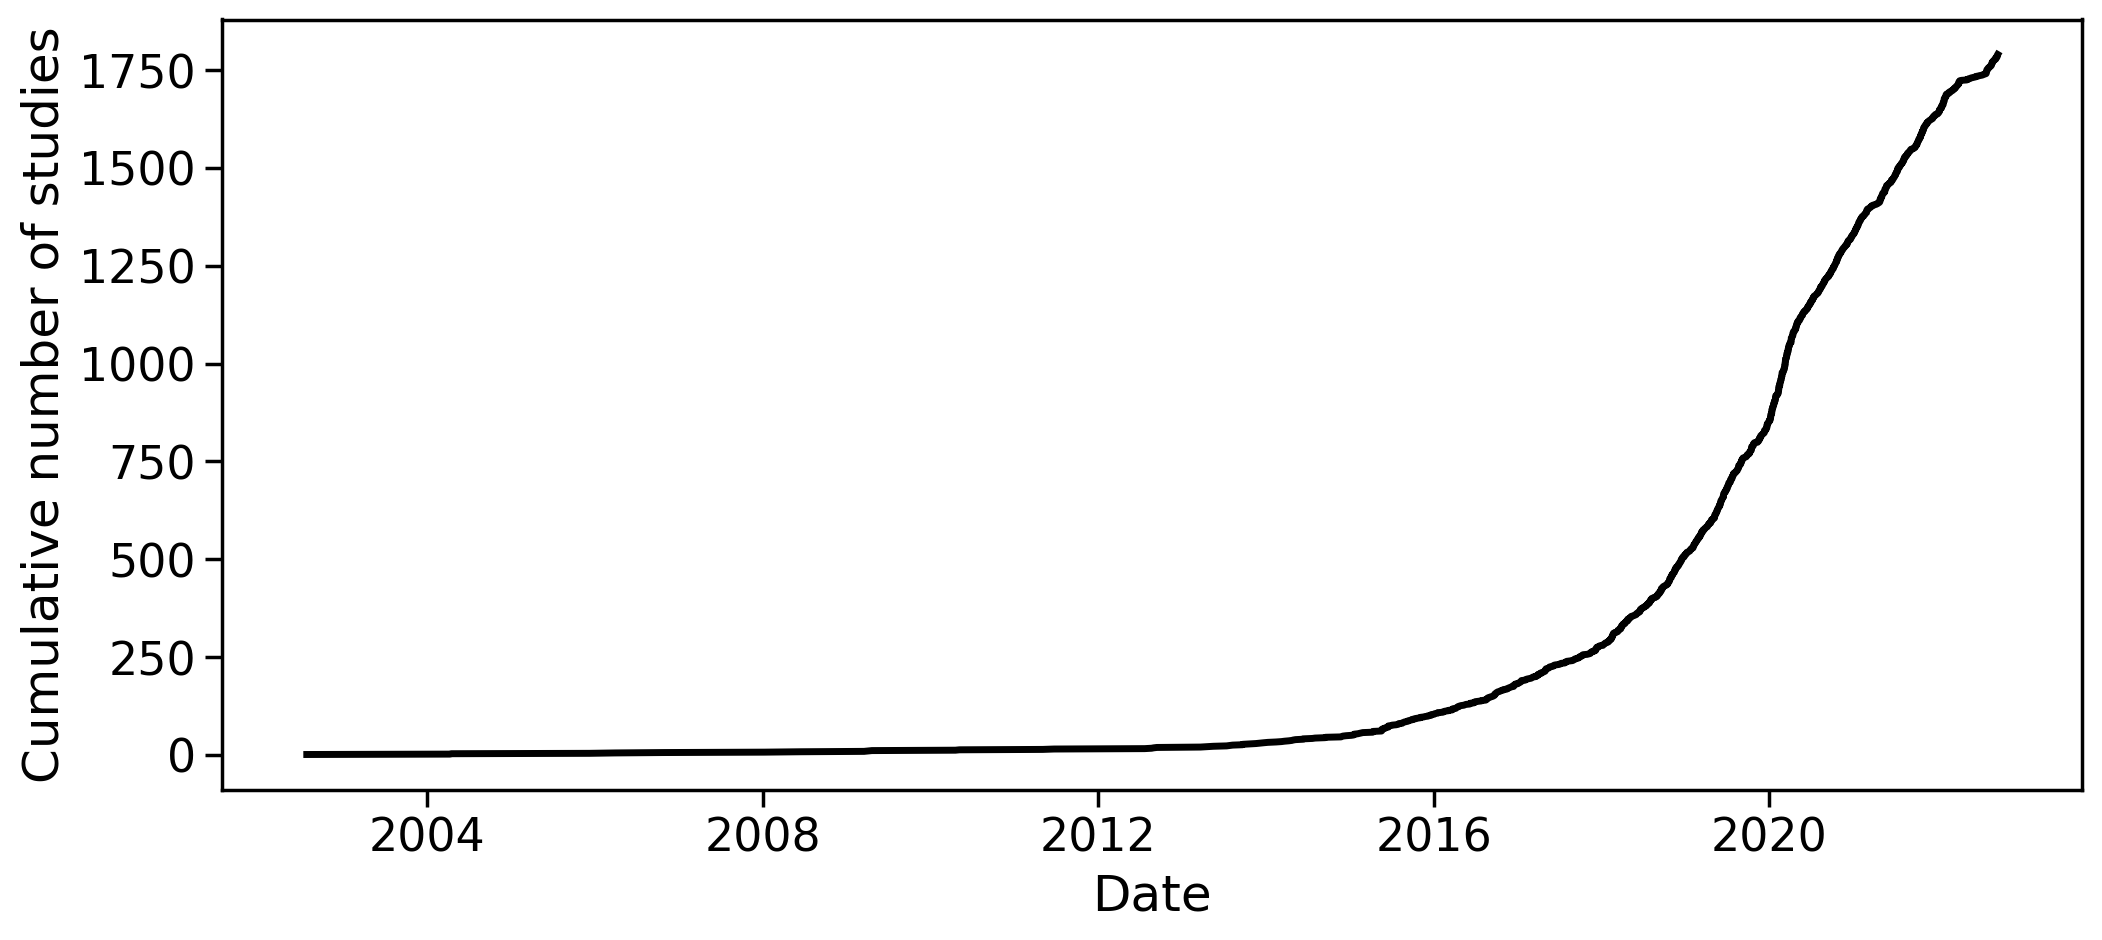

In [8]:
#@title Growth of single-cell RNA-seq
df = pd.read_csv('http://nxn.se/single-cell-studies/data.tsv', sep='\t')
# converts string to date format, can only be run once!
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# converts string of reported cells total to float, can only be run once!
df['Reported cells total'] = df['Reported cells total'].str.replace(',', '').map(float)

# plot number of studies over time
fig, ax = plt.subplots(figsize=(12, 5))

papers = pd.read_csv('http://nxn.se/single-cell-studies/data.tsv', sep='\t')
papers['Datetime'] = pd.to_datetime(papers['Date'], format='%Y%m%d')
papers = papers.sort_values("Date")
papers["count"] = 1

x = papers.Datetime
y = papers["count"].groupby(papers.Datetime.dt.time).cumsum()

ax.plot(x, y, color="k")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative number of studies")

plt.show()

There are many different scRNA-seq technologies in use and under development, but broadly they fall into a few categories
-  well-based methods (e.g. Fluidigm SMARTer C1, Smart-seq2)
- droplet-based methods (e.g. Drop-seq, InDrops, 10X Genomics Chromium)
- spatial transcriptomics approaches (e.g. MERFISH, SEQFISH)

At the time of initial writing of this document (2019), droplet-based approaches have become popular due to their relative low-cost, easy of use, and scalability. This is evident in a breakdown of articles by technology used: 

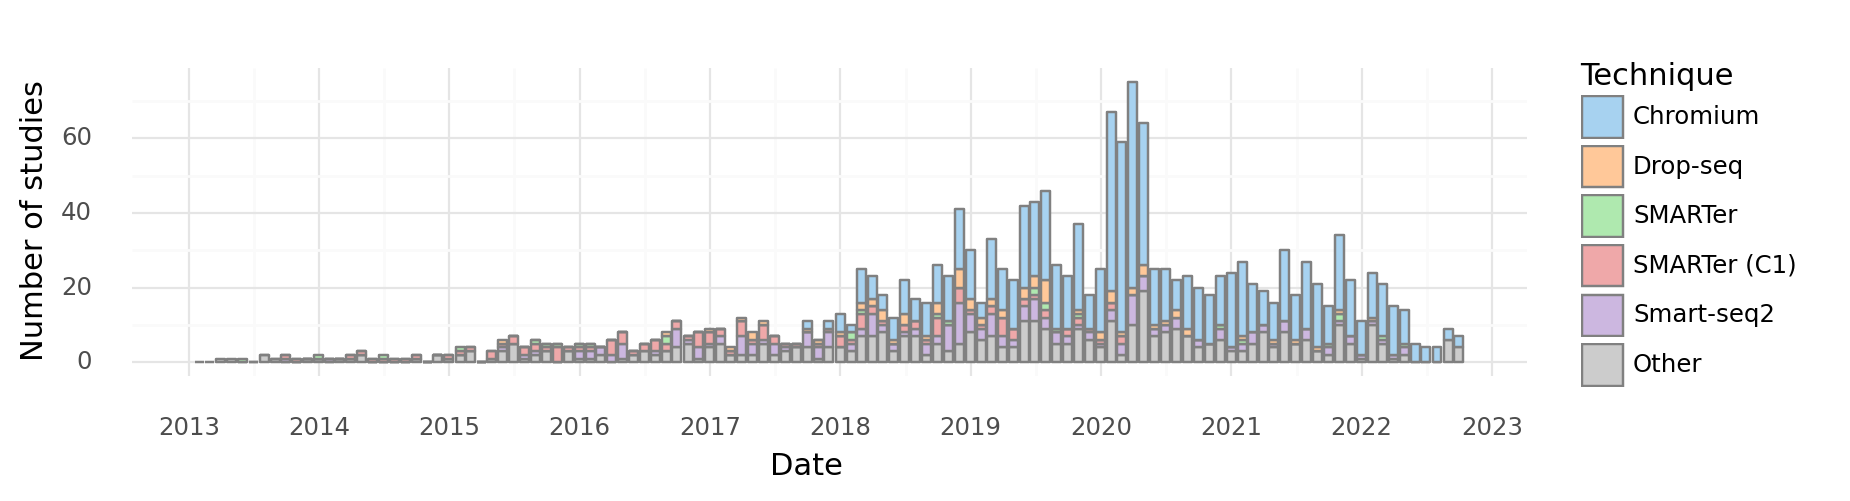

<ggplot: (8746435073931)>

In [27]:
#@title Technologies used
def tidy_split(df, column, sep='|', keep=False):

    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    
    return new_df

tdf = tidy_split(df, 'Technique', ' & ')
t_dict = {k: k for k in tdf['Technique'].value_counts().head(5).index}
tdf['Technique'] = tdf['Technique'].map(lambda s: t_dict.get(s, 'Other'))
techs = list(
    tdf['Technique']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')
tdf['Technique'] = (
    pd.Categorical(
       tdf['Technique'],
        categories=techs,
        ordered=True
    )
)

def desaturate(color, prop):
    
    # Check inputs
#     if not 0 <= prop <= 1:
#         raise ValueError("prop must be between 0 and 1")

    # Get rgb tuple rep
    rgb = mplcol.colorConverter.to_rgb(color)

    # Convert to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # Desaturate the saturation channel
#     l *= prop
    l = 0.8

    # Convert back to rgb
    new_color = colorsys.hls_to_rgb(h, l, s)
    
    hex_color = '#{:02x}{:02x}{:02x}'.format(*map(lambda c: int(c * 255), new_color))

    return hex_color

    # lighten matplotlib default colors
clrs = list(map(lambda c: desaturate(c, 1.2), ['C0', 'C1', 'C2', 'C3', 'C4', 'black']))

#### Plot number of studies per month by technique
per_month = (
    tdf
    .groupby('Technique')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)

p.options.figure_size = (9, 2)
fig = (
    p.ggplot(
        per_month.query('Date > 2013'),
        p.aes(x='Date', y='DOI', fill='Technique'),
    )
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='DejaVu Sans')
    + p.scale_x_datetime(
        breaks=date_breaks('1 years'),
        labels=date_format('%Y')
    )
    + p.labs(y='Number of studies')
    + p.scale_fill_manual(clrs)
)
fig

We therefore restrict this exposition to droplet-based technologies.

## Droplet-based methods

Droplet based single-cell RNA-seq methods were popularized by a pair of papers published concurrently in 2015: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002 - describes Drop-seq.
- Klein et al., [Droplet barcoding for single-cell transcriptomics applied to embryonic stem cells](https://www.cell.com/cell/fulltext/S0092-8674(15)00500-0), 2015. DOI:10.1016/j.cell.2015.04.044 - descibes inDrops.

Both of the methods makes use of developments in microfluidics published in:
- Song, Chen, Ismagilov, [Reactions in droplets in microfluidic channels](https://onlinelibrary.wiley.com/doi/10.1002/anie.200601554), 2006. DOI:10.1002/anie.200601554
- Guo, Rotem, Heyman and Weitz, [Droplet microfluidics for high-throughput biological assays](https://pubs.rsc.org/en/content/articlelanding/2012/lc/c2lc21147e#!divAbstract), 2012. DOI:10.1039/C2LC21147E

### Overview
An overview of how a droplet based scRNA-seq method works is illustrated in a figure from the Drop-seq [Macosko et al. 2015](https://www.cell.com/fulltext/S0092-8674(15)00549-8) paper:

![Droplet scRNA-seq](https://ars.els-cdn.com/content/image/1-s2.0-S0092867415005498-fx1.jpg)

A microfluidic device is used to generate an emulsion, which  consists of aqueous droplets in oil. The droplets are used to encapsulate cells, beads and reagents. In other words, each droplet is a "mini laboratory" in which the RNA from a single-cell can be captured and prepared for identification. Thus, the consistuent parts are as follows:

- an emulsion (white circles containing beads and cells on the right hand-side of the figure). 
- dissociated cells (depicted as odd-shaped colored objects in the figure).
- beads (flowing in from the left hand side of the figure).

### Emulsions
The foundation of droplet based single-cell RNA-seq methods are *mono-dispersed emulsions*. Mono-dispersed refers to the requirements that droplets are of (near) uniform size. Mono-dispersed emulsions can be generated with a microfluidic device, as shown below. The droplets are being "pinched off" at the junction, and one can see a polystyrene bead being captured in one droplet, while others are empty.

![alt text](http://mccarrolllab.org/wp-content/uploads/2015/05/Substack-4455-4504.gif)

The movie is from the [McCarolll Drop-seq tutorial](http://mccarrolllab.org/dropseq/) courtesy of Patrick Stumpf, Matthew Rose-Zerilli, Rosanna Smith, Martin Fischlechner & Jonathan West at the Centre for Hybrid Biodevices & Cancer Sciences Unit at the University of Southampton.


### Beads
![alt text](https://els-jbs-prod-cdn.literatumonline.com/cms/attachment/5bf7541c-af0d-4a13-a806-c014bee07359/gr2.jpg)

The figure above, reproduce from Klein et al. 2015, shows the procedure used to make hydrogel beads for inDrops. Every bead contains the same barcode sequence, while the barcode sequences on two different beads are distinct. 

The barcode and UMI structure for a variety of technologies is viewable in a [compilation](https://teichlab.github.io/scg_lib_structs/) by Xi Chen.

### Single cell suspensions

In order to assay the transcriptomes of individual cells with droplet-based single-cell RNA-seq technologies, it is necessary to first dissociate tissue. Procedures for tissue dissociation are varied, and highly dependent on the organism, type of tissue, and many other factors. Protocols may be be enzymatic, but can also utilize mechanical dissociators. The [talk below provides an introduction to tissue handling and dissociation](https://www.youtube.com/watch?v=ARozvI4AbS8).

## Statistics of beads & cells in droplets

### The binomial distribution

An understanding of droplet-based single-cell RNA-seq requires consideration of the statistics describing the capture of cells and beads in droplets. Suppose that in an experiment multiple droplets have been formed, and focus on one of the droplets. Assume that the probability that any single one of $n$ cells were captured inside it is $p$. We can calculate the probability that $k$ cells have been captured in the droplet as follows:

$$\mathbb{P}(\text{Droplet contains k cells}) = \binom{n}{k}p^k(1-p)^{n-k}$$

The expected number of cells in the droplet is 

$$\lambda := \sum_{k=0}^n k \binom{n}{k}p^k(1-p)^{n-k} = n \cdot p$$ 

We plot this distribution on number of cells in a droplet below. It is called the Binomial distribution and has two parameters: $n$ and $p$.

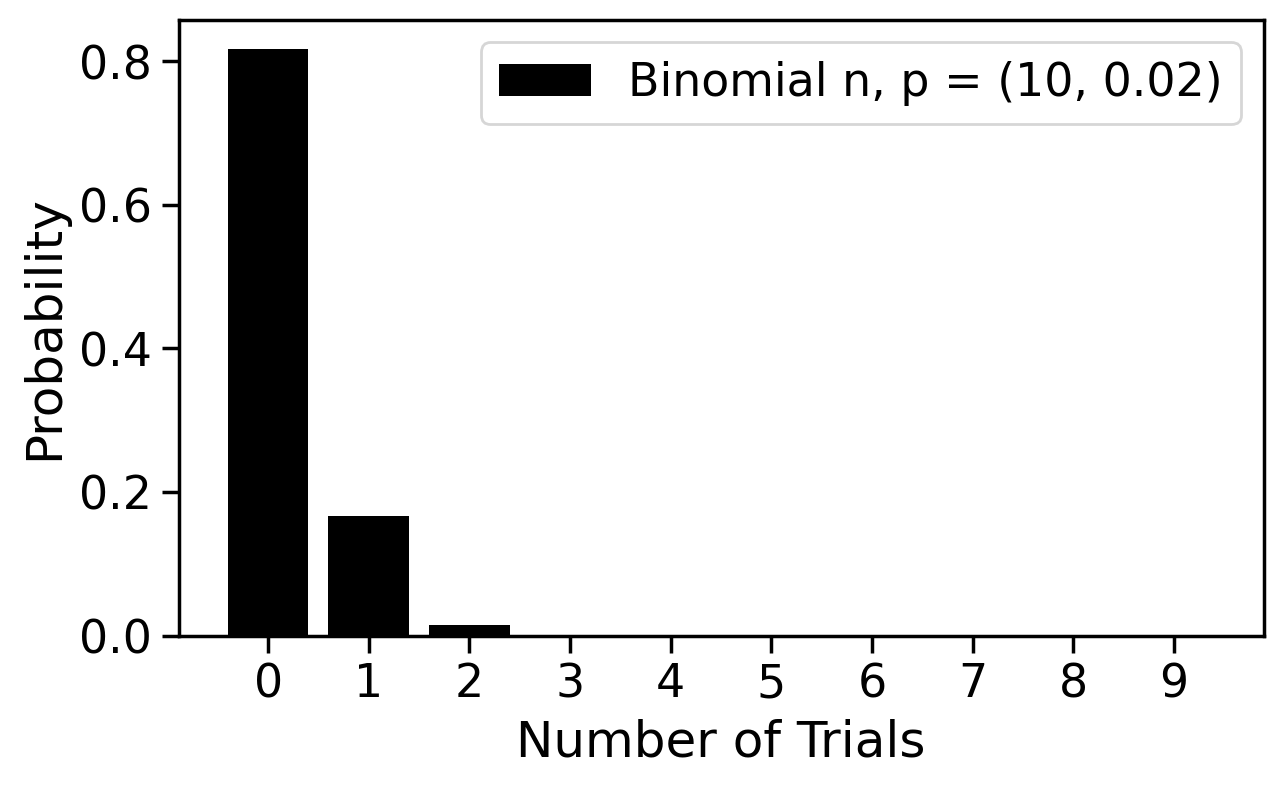

In [32]:
#@title Binomial distribution { run: "auto" }
n =  10#@param {type:"integer"}
p = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
fig, ax = plt.subplots(figsize=(7, 4))
s = 10

x = np.arange(s)
y = binom.pmf(x,n,p)

ax.bar(x, y, color="k", label="Binomial n, p = ({}, {})".format(n,p))
ax.set_xlabel("Number of Trials")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.legend()

plt.show()

With $n=10$ and $p=0.02$, it's quite probable that the droplet is empty, and while possible that it contains one cell, unlikely that it has 2 or more. This is a good regime for a single-cell experiment; we will see that it is problematic if two cells are captured in a single droplet. Empty droplets are not problematic in the sense that they will not lead to data, and can therefore be ignored.

### The Poisson distribution

The Binomial distribution can be difficult to work with in practice. Suppose, for example, that $n=1000$ and $p=0.002$. Suppose that we are interested in the probability of seeing 431 cells in a droplet. This probability is given by 

$$\binom{1000}{421}0.02^{421}(1-0.02)^{1000-431}$$

which is evidently a difficult number to calculate exactly.

A practical alternative to the binmomial is the Poisson distribution. The Poisson distribution has one parameter, and its support is the non-negative integers. A random variable $X$ is Poisson distributed if
$$\mathbb{P}(X=k)\quad = \quad \frac{e^{-\lambda}\lambda^k}{k!}$$

The Poisson limit theorem states that if $p_n$ is a sequence of real numbers in $[0,1]$ with the sequence $np_n$ converging to to a finite limit $\lambda$, then
$$\lim_{n \rightarrow \infty} \binom{n}{k}p_n^{k}(1-p_n)^{n-k} = e^{-\lambda}\frac{\lambda^k}{k!}$$

Thus, the Poisson distribution serves as a useful, tractable distribution to work with in lieu of the Binomial distribution for large $n$ and small $p$.

The histogram below can be used to explore the Poisson and its relationship to the binomial 

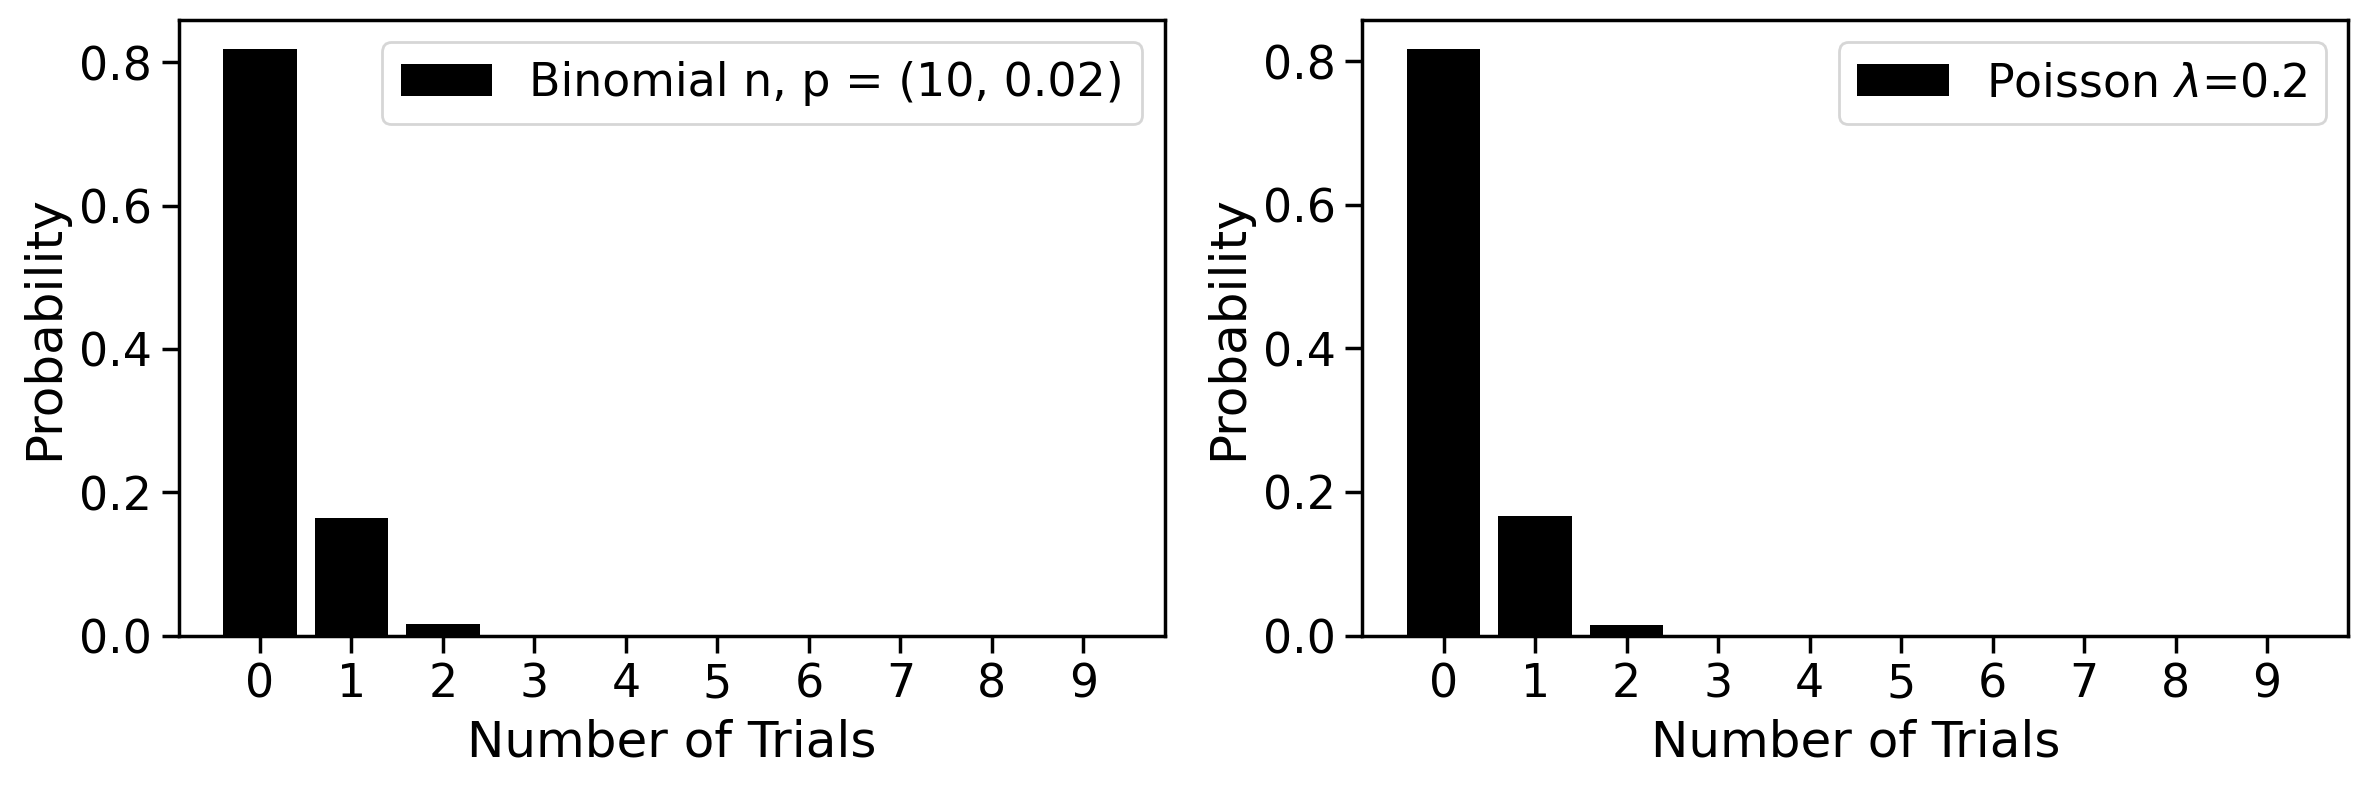

In [33]:
#@title Binomial - Poisson comparison { run: "auto" }

n =  10#@param {type:"integer"}
p = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}

s = 10
lambda_param = n*p

fig, ax = plt.subplots(figsize=(14, 4), ncols=2)

x = np.arange(s)
y = poisson.pmf(x, lambda_param)

ax[0].bar(x, y, color="k", label="Binomial n, p = ({}, {})".format(n,p))
ax[0].set_xlabel("Number of Trials")
ax[0].set_ylabel("Probability")
ax[0].set_xticks(x)
ax[0].legend()

x = np.arange(s)
y = binom.pmf(x,n,p)

ax[1].bar(x, y, color="k", label="Poisson $\lambda$={}".format(lambda_param))
ax[1].set_xlabel("Number of Trials")
ax[1].set_ylabel("Probability")
ax[1].set_xticks(x)

ax[1].legend()

plt.show()

We therefore posit that 

$\mathbb{P}(\text{Droplet contains k cells}) = \frac{e^{-\lambda}\lambda^k}{k!}$ and 
$\mathbb{P}(\text{Droplet contains j beads}) = \frac{e^{-\mu}\mu^j}{j!}$


## Droplet tuning

### Cell capture and bead overload

The cell capture rate is the probability that a droplet has at least one bead, and is given by $1-e^{-\mu}$.

The bead overload rate is the rate at which captured single cells are associated with two or more different barcodes, which will happen when multiple beads are loaded into a droplet with one cell. The probability this happens is $$\frac{1-e^{-\mu}-\mu e^{-\mu}}{1-e^{-\mu}}.$$ 

This leads to a tradeoff, as shown below.


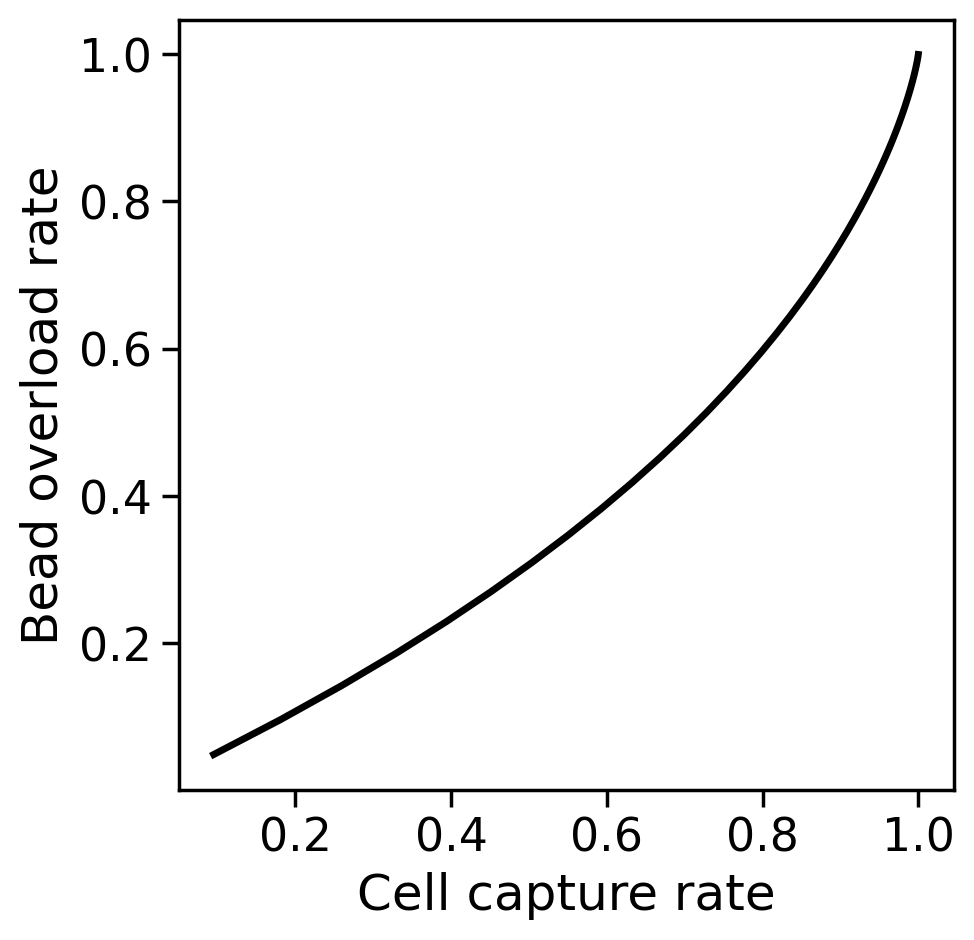

In [34]:
#@title Tradeoff { run: "auto" }
fig, ax = plt.subplots(figsize=(5,5))

mu = np.arange(0, 10, 0.1)

x = 1 - np.exp(-mu)
y = (1 - np.exp(-mu)-mu*np.exp(-mu))/(1-np.exp(-mu))

ax.plot(x, y, color='k')
ax.set_xlabel("Cell capture rate")
ax.set_ylabel("Bead overload rate")

plt.show()

### Sub-Poisson loading

In order to circumvent the limit posed by a Poisson process for beads in droplets, the inDrops method uses tightly packed hydrogel beads that can be injected into droplets without loss. This approach, which leads to "[sub-Poisson loading](https://liorpachter.wordpress.com/tag/hydrogel-beads/
)" is also used by 10X Genomics, and allows for increased capture rate.

The difference is shown in two videos from the [Abate lab](https://www.abatelab.org/) linked to below. The first video, shows beads loaded being loaded in droplets with Poisson statistics:


In [43]:
#@title Poisson loading
HTML('<iframe width="688" height="387" src="https://www.youtube.com/embed/usK71SG30t0?autoplay=1&loop=1&playlist=usK71SG30t0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

The next video shows sub-Poisson loading with hydrogel beads. In this case the flow rate has been set so that exactly two beads are situated in each droplet.

In [44]:
#@title Sub-Poisson loading { run: "auto" }
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/2q1Lt9DWmRQ?autoplay=1&loop=1&playlist=2q1Lt9DWmRQ" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

The following shows the types of beads used for different droplet-based scRNA-seq methods, and associated properties:

 Property | Drop-seq | inDrops | 10x genomics 
---| --- | --- |--- 
Bead material | Polystyrene | Hydrogel | Hydrogel
Loading dynamics | Poisson | sub-Poisson | sub-Poisson
Dissolvable | No | No | Yes
Barcode release | No | UV release | Chemical release
Customizable | Demonstrated | Not shown | Feasible
Licensing | Open source | Open Source | Proprietary
Availability | Beads are sold | Commercial | Commercial


### Barcode collisions

Barcode collisions arise when two cells are separately encapsulated with beads that happen to contain identical barcodes.

For $n$ assayed cells with $m$ barcodes, the barcode collision rate is the expected proportion of assayed cells that did not receive a unique barcode, i.e.

$$1-\frac{\mathbb{E}[\text{cells with a unique barcode}]}{\text{number of cells}}$$

$$= 1-(1-\frac{1}{m})^{n-1} \approx 1-\left(\frac{1}{e}\right)^\frac{n}{m}$$

Avoiding barcode collisions requires high barcode diversity, i.e. a small ratio of $\frac{n}{m}$.

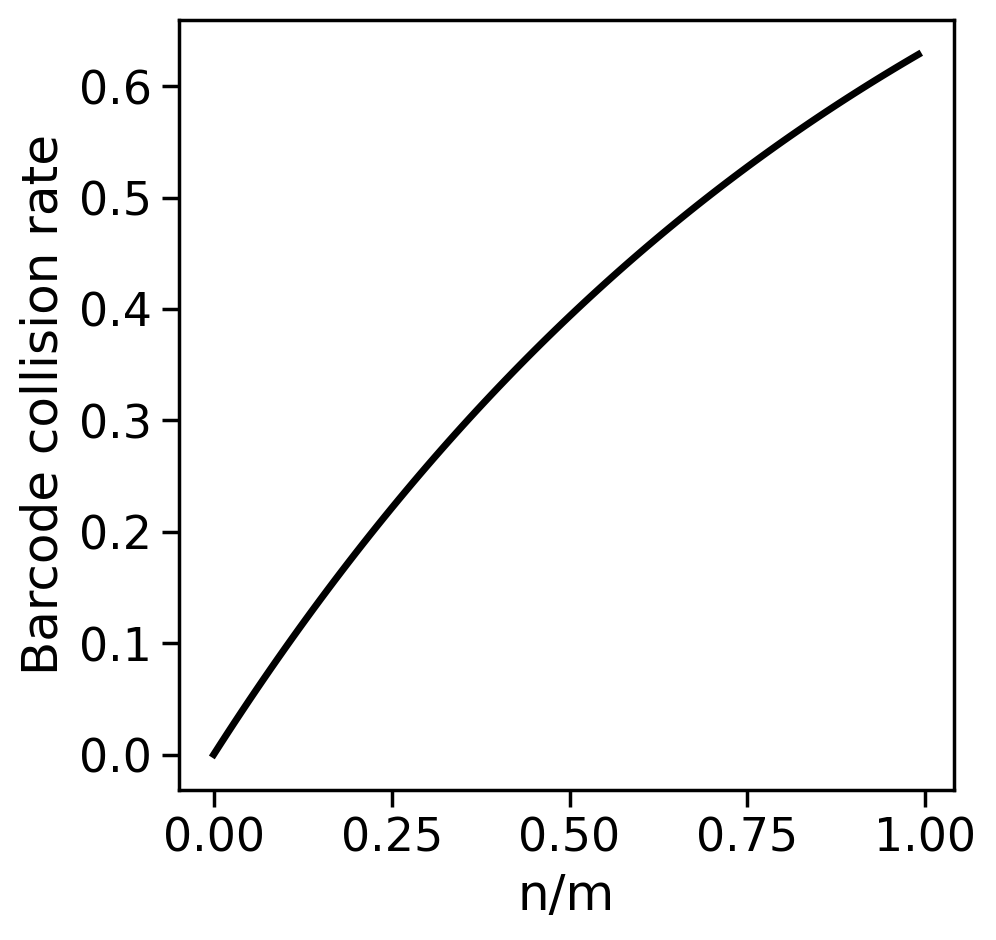

In [45]:
#@title Diversity and collisions  { run: "auto" }
fig, ax = plt.subplots(figsize=(5,5))

bc = np.arange(0, 1, 0.01)

x = bc
y = 1 - np.exp(-bc)

ax.plot(x, y, color='k')
ax.set_xlabel("n/m")
ax.set_ylabel("Barcode collision rate")

plt.show()

### Barcode diversity and length
A 1% barcode collision rate requires a barcode diversity of ~1%, i.e. the number of barcodes should be 100 times the number of cells. The number of barcodes from a sequence of length $L$ is $4^L$. Therefore, to assay $n$ cells, the barcode sequence must be of length at least $log_4n+3\frac{1}{3}$. This is a minimum and does not account for the need to be robust to sequencing errors.

### Technical doublets
Technical doublets arise when two or more cells are captured in a droplet with a single bead. The technical doublet rate is therefore the probability of capturing two or more cells in a droplet given that at least one cell has been captured in a droplet:

$\frac{1-e^{-\lambda}-\lambda e^{-\lambda}}{1-e^{-\lambda}}$.

Note that "overloading" a droplet-based single-cell experiment by loading more cells while keeping flow rates constant will increase the number of technical doublets due to an effective increase in $\lambda$ and also the number of synthetic doublets due to an increase in barcode diversity.


#### The barnyard plot

Technical doublet rates can be measured by experiments in which a mixture of cells from two different species are assayed together. For example, if mouse and human cells are pooled prior to single-cell RNA-seq, the resultant reads ought to be assignable to either human or mouse. If a droplet contained a "mixed" doublet, i.e. two cells one of which is from human and the other from mouse, it will generate reads some of which can be aligned to mouse, and some to human.

An example from a 10X Genomics dataset ([5k 1:1 mixture of fresh frozen human (HEK293T) and mouse (NIH3T3) cells](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.2/5k_hgmm_v3_nextgem)) is shown in the plot below, which is called a *Barnyard plot* in Macosko et al. **2015**.


In [46]:
%%capture
# Download a matrix of human and mouse
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/hgmm_1k_v2/hgmm_1k_v2_filtered_feature_bc_matrix.tar.gz
!tar -xvf hgmm_1k_v2_filtered_feature_bc_matrix.tar.gz
!rm hgmm_1k_v2_filtered_feature_bc_matrix.tar.gz


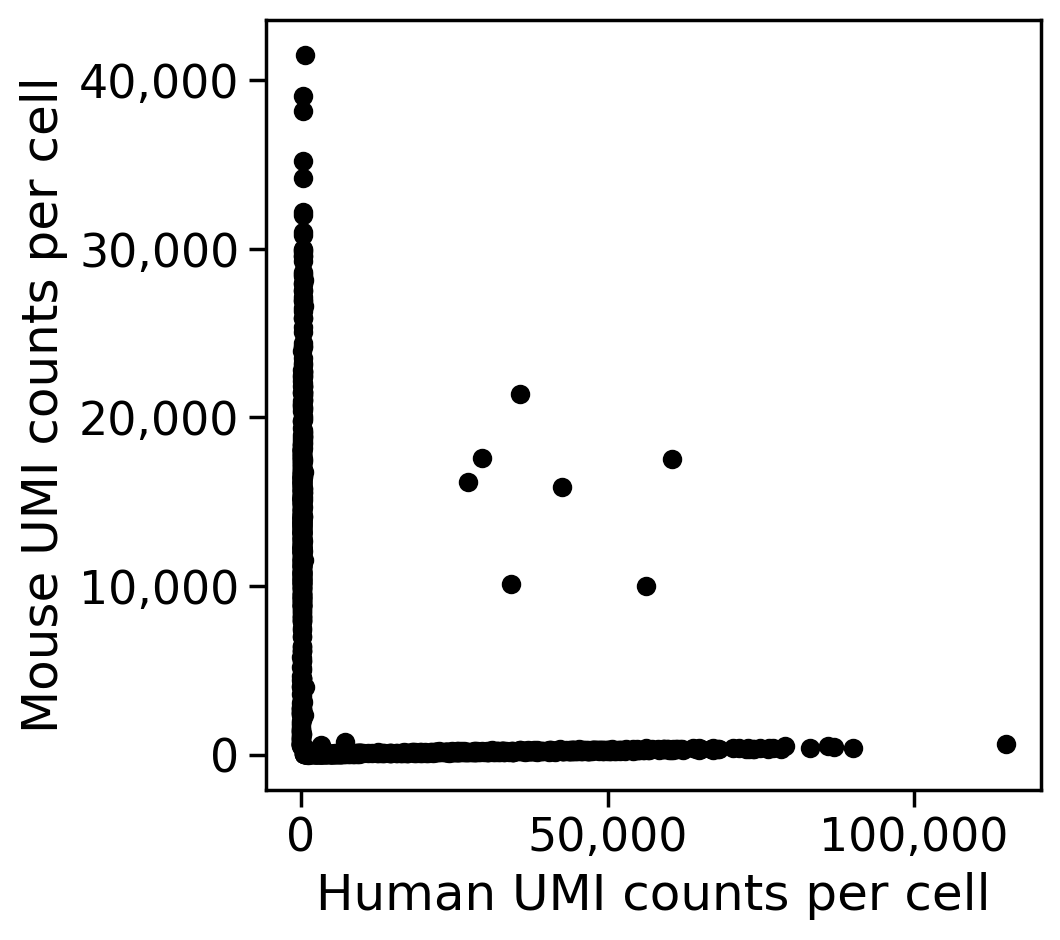

In [51]:
#@title Human & mouse PBMCs 
mtx = csr_matrix(mmread("filtered_feature_bc_matrix/matrix.mtx.gz").T)
genes = pd.read_csv("filtered_feature_bc_matrix/features.tsv.gz", header=None, names=["gene_id", "gene_name", "extra"], sep="\t")
cells = pd.read_csv("filtered_feature_bc_matrix/barcodes.tsv.gz", header=None, names=["cell_barcode"], sep="\t")

adata = anndata.AnnData(X=mtx, var=genes, obs=cells)
adata.var["human"] = adata.var["gene_id"].str.contains("hg19").values

x = (mtx[:,adata.var["human"].values]).sum(axis=1)
y = (mtx[:,~adata.var["human"].values]).sum(axis=1)

fig, ax = plt.subplots(figsize=(5,5))

x = np.asarray(x).reshape(-1)
y = np.asarray(y).reshape(-1)

ax.scatter(x, y, color='k')

ax.set_xlabel("Human UMI counts per cell")
ax.set_ylabel("Mouse UMI counts per cell")

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


plt.show()


THe plot shows that there are only 7 doublets out of 5,000 cells in this experiment. This is an unusually small number and atypical of most experiments, where doublet rates are between 5%--15% (see [DePasquale et al. 2018](https://www.biorxiv.org/content/10.1101/364810v1.abstract));  perhaps the 5k human mouse PBMC dataset data is articularly "clean" as it is an advertisement distributed by 10X Genomics.

Note: may there be pure human and pure mouse cell doublets, e.g., with UMI counts per cell > 75,000?

#### Bloom's correction

The 7 doublets identifiable by eye in the plot above are all *mixed doublets*, i.e. they contain one human and one mouse cell. However doublets may consist of two mouse cells, or two human cells. If the number of droplets containing at least one human cells is $n_1$, the number containing at least one mouse cell is $n_2$, and the number of mixed doublets is $n_{1,2}$, then an estimate for the actual doublet rate can be obtained from the calculation below ([Bloom 2018](https://peerj.com/articles/5578/)):

Given $n_1, n_2$ and $n_{1,2}$ as described above (note that $n_1$ is the number of cells on the *x* axis + the number of mixed doublets and $n_2$ is the number of cells on the *y* axis + the number of mixed doublets), then in expectation

$$\frac{n_1}{N} \cdot \frac{n_2}{N} = \frac{n_{1,2}}{N}$$

where $N$ is the total number of droplets. From this we see that

$$\hat{N} = \frac{n_1 \cdot n_2}{n_{1,2}}$$

This is the maximum likelihood [Lincoln-Petersen estimator](https://en.wikipedia.org/wiki/Mark_and_recapture) for population size from mark and recapture. 

Let $\mu_1$ nad $\mu_2$ be the Poisson rates for the respective types of cells, i.e. the average number of cells of each type per droplet. Then 

$\hat{\mu}_1 = -\text{ln } \left( \frac{N-n_1}{N} \right)$ and
$\hat{\mu}_2 = -\text{ln } \left( \frac{N-n_2}{N} \right)$

From this the doublet rate $D$ can be estimated as 

$$\hat{D} = 1 - \frac{(\mu_1+\mu_2)e^{-\mu_1+\mu_2}}{1-e^{-\mu_1-\mu_2}}$$


### Biological doublets

Biological doublets arise when two cells form a discrete unit that does not break apart during disruption to form a single-cell suspension. Note that biological doublets cannot be detected in barnyard plots. 

One approach to avoiding biological doublets is to perform single-nuclei RNA-seq. See, e.g. [Habib et al., 2017](https://www.nature.com/articles/nmeth.4407). However, biological doublets are not necessarily just a technical artifact to be avoided. [Halpern et al., 2018](https://www.nature.com/articles/nbt.4231) utilizes biological doublets of hepatocytes and liver endothelial cells to assign tissue coordinates to liver endothelial cells via imputation from their hepatocyte partners.

### Unique Molecular Identifiers

The number of distinct UMIs on a bead in a droplet is at most $4^L$ where $L$ is the number of UMI bases. For example, for 10X Genomics v2 technology $L=10$ and for 10X Genomics v3 technology $L=12$. [Melsted, Booeshaghi et al. 2019](https://www.biorxiv.org/content/10.1101/673285v2) show how to estimate the number of the actual distinct UMIs on each bead for which data is obtained in a scRNA-seq experiment.


## Summary

Selection of a single-cell RNA-seq method requires choosing among many tradeoffs that reflect the underlying technologies. The table below, from From [Zhang et al. 2019. DOI:10.1016/j.molcel.2018.10.020](https://www.sciencedirect.com/science/article/pii/S1097276518308803?via%3Dihub), summarizes the three most popular droplet-based single-cell RNA-seq assays:

![alt text](https://ars.els-cdn.com/content/image/1-s2.0-S1097276518308803-gr1.jpg)



The generation of single-cell RNA-seq data is just the first step in understanding the transcriptomes cells. To interpret the data reads must be aligned or pseudoaligned, UMIs counted, and large *cell x gene* matrices examined. The growth in single-cell RNA-seq analysis *tools* for these tasks has been breathtaking. The graph below, plotted from real-time data downloaded from the [scRNA-seq tools database](https://www.scrna-tools.org/tools), shows the number of tools published since 2016. 

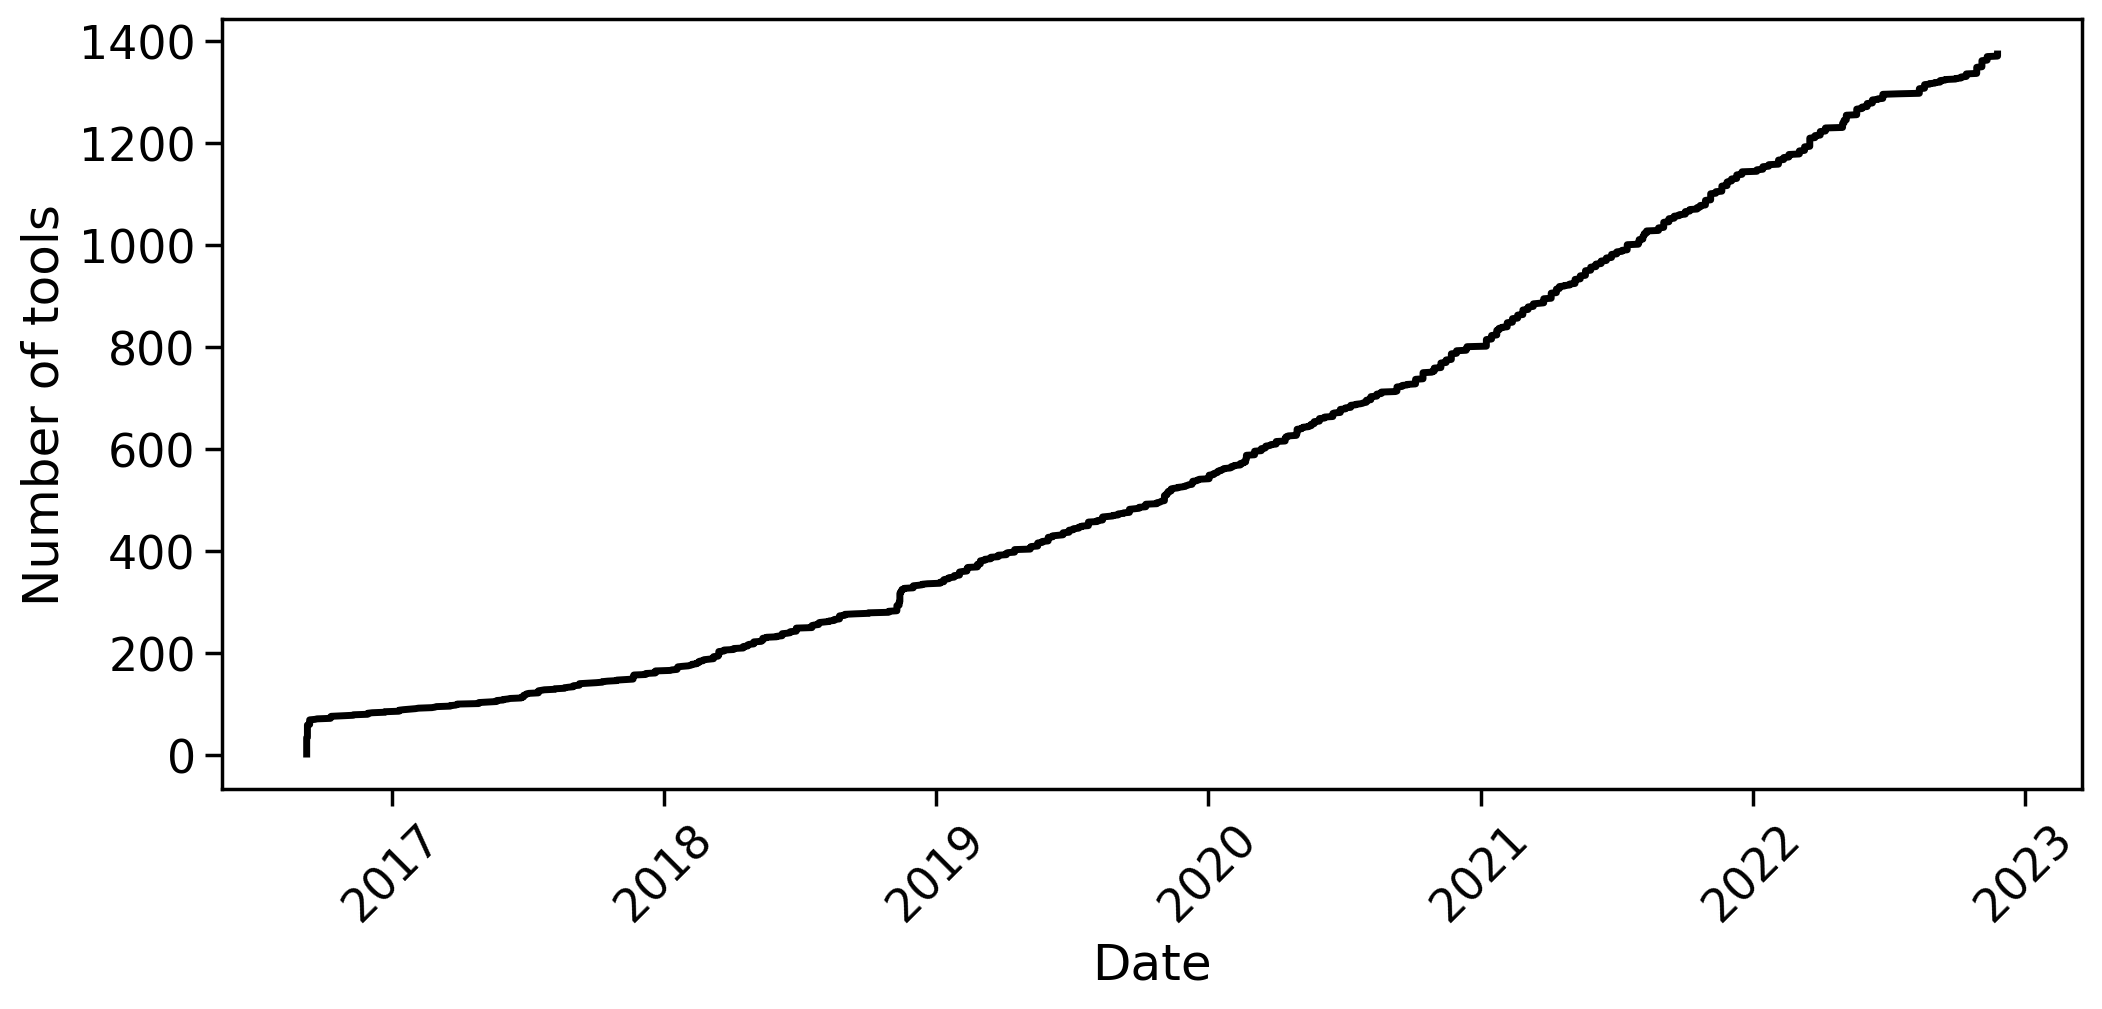

In [52]:
#@title Growth of single-cell tools { run: "auto" }
tools = pd.read_csv('https://raw.githubusercontent.com/Oshlack/scRNA-tools/master/database/tools.tsv', sep='\t')
tools["Datetime"] = pd.to_datetime(tools["Added"])
tools = tools.sort_values("Added")
tools["count"] = 1

fig, ax = plt.subplots(figsize=(12, 5))

x = tools.Datetime
y = tools["count"].groupby(tools.Datetime.dt.time).cumsum()

ax.plot(x, y, color="k")
ax.set_xlabel("Date")
ax.set_ylabel("Number of tools")
ax.tick_params(axis='x', rotation=45)



plt.show()

In fact, the rate of growth of single-cell RNA-seq *tools* is similar to that of single-cell RNA-seq *studies*:

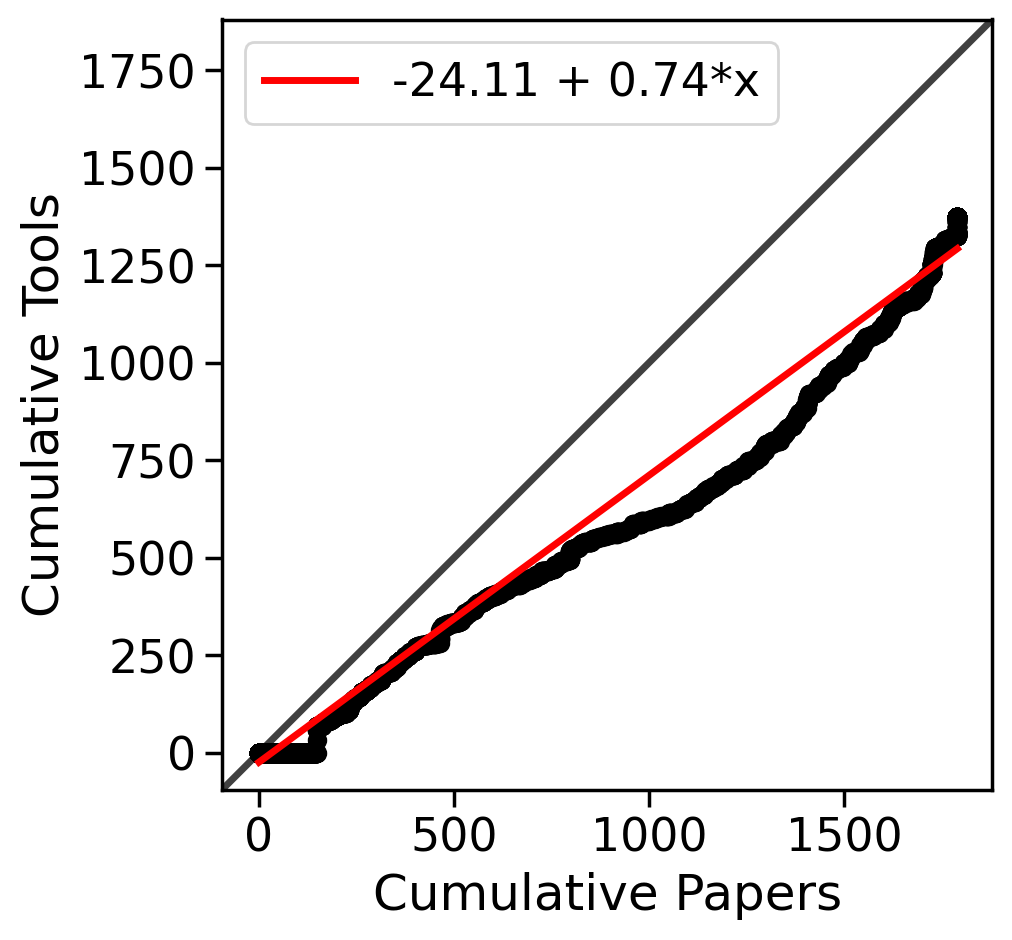

In [53]:
#@title scRNA-seq tools vs. studies linear regression
date_papers = papers.groupby("Datetime")["count"].sum()
date_tools = tools.groupby("Datetime")["count"].sum()
dates = pd.date_range(start='7/26/2002', end='01/01/2025')
combined = pd.DataFrame(index=dates)
combined["tool_counts"] = combined.index.map(date_tools)
combined["paper_counts"] = combined.index.map(date_papers)
combined = combined.fillna(0)
combined["Datetime"] = combined.index.values

fig, ax = plt.subplots(figsize=(5,5))

x = combined["paper_counts"].groupby(combined.Datetime.dt.time).cumsum()
y = combined["tool_counts"].groupby(combined.Datetime.dt.time).cumsum()

ax.scatter(x, y, color="k")
regr = linear_model.LinearRegression()
x = x.values[:, np.newaxis]
regr.fit(x, y.values)
xx = np.linspace(0, max(x), 200)
yy = regr.intercept_ + regr.coef_*xx
ax.plot(xx, yy, color="r", label=f"{regr.intercept_:,.2f} + {regr.coef_[0]:,.2f}*x")

lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel("Cumulative Papers")
ax.set_ylabel("Cumulative Tools")
ax.legend()

plt.show()

Next step: to learn how to analyze single-cell RNA-seq data, visit the [kallistobus.tools site tutorials](https://www.kallistobus.tools/tutorials) site and explore the "Introduction 1: pre-processing and quality control" notebook in [Python](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_1_python.ipynb) or [R](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_1_R.ipynb).

**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/Introduction_single_cell_RNA_seq.ipynb).